In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def bar_plot(dataset, feature):
    plt.bar(dataset[feature].value_counts().index, dataset[feature].value_counts())
    plt.xticks(dataset[feature].value_counts().index)
    plt.title(f'Bar plot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('counts')
    plt.show()

In [3]:
def plot_hist(dataset, feature):
    plt.hist(dataset[feature], bins = 'fd')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('counts')
    plt.show()

## Data reading and cleaning

### Read data

In [4]:
data = pd.read_csv('data/train.csv')

In [5]:
data.head(1)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.0,0.0,100.0,1849,4


In [6]:
data.shape

(9557, 143)

The data has 143 features with 9557 records.

### Missing data

In [7]:
missing_data = data.isna().sum()

In [8]:
missing_data[missing_data != 0]

v2a1         6860
v18q1        7342
rez_esc      7928
meaneduc        5
SQBmeaned       5
dtype: int64

There are missing values for only 5 columns of all 143. The missing data percentag is as follows:
- 71% for montly rent payment `v2a1`
- 76% for the number of tablets household owns `v18q1`
- 82% for years behind in school `rez_esc`
- less than 1% for average years of education for adults (18+) `meaneduc`
- less than 1% for square of the mean years of education of adults (>=18) in the household `SQBmeaned`

The first tree have too much missing data to be imputed good enough, so those will be dropped. `meaneduc` and `SQBmeaned` are realeted and show pretty much same information. With only 5 missing records they can easily be imputed.

In [9]:
data['meaneduc'] = data['meaneduc'].fillna(data['meaneduc'].mean())

In [10]:
assert data['meaneduc'].isna().any() == False

In [11]:
data = data.drop(['v2a1', 'v18q1', 'rez_esc'], axis = 1)

## Feature selection

Some of the features will be deleted, because the information provided by them is covered by another feature or are id related. Those features are:
- `Id` and `idhogar` are ID related
- `hacapo` and `hacdor` are binary categorical related to overcrowding by room and bedrooms respectively; similar information is present in `overcrowding`
- `r4h1`, `r4h2`, `r4h3`, `r4m1`, `r4m2`, `r4m3`, `r4t1`, `r4t2`, `r4t3` are related to the number of males, females and people younger than 12 years, older and the total; the year information is covered in the `dependency`
- `parentesco2`, `parentesco3`, `parentesco4`, `parentesco5`, `parentesco6`, `parentesco7`, `parentesco8`, `parentesco9`, `parentesco10`, `parentesco11`, `parentesco12` are showing the family relation; those have very low correlation with he target as shown below
- `mobilephone` is binary categorical feature, which shows if household have a mobile phone; that information is also presents in `qmobilephone`, which consists of the total number of phones, with 0 for no phone

In [12]:
data[['Target', 'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7',
      'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12']].corr()

,Target,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12
Target,1.000000,0.057042,-0.053989,-0.020887,0.016534,-0.068125,0.006216,0.008562,0.012318,0.010990,-0.019076,0.014421
parentesco2,0.057042,1.000000,-0.373257,-0.052646,-0.046567,-0.110291,-0.047842,-0.023327,-0.055117,-0.026652,-0.053782,-0.044454
parentesco3,-0.053989,-0.373257,1.000000,-0.087114,-0.077056,-0.182501,-0.079165,-0.038601,-0.091204,-0.044101,-0.088995,-0.073560
parentesco4,-0.020887,-0.052646,-0.087114,1.000000,-0.010868,-0.025741,-0.011166,-0.005444,-0.012864,-0.006220,-0.012552,-0.010375
parentesco5,0.016534,-0.046567,-0.077056,-0.010868,1.000000,-0.022769,-0.009877,-0.004816,-0.011378,-0.005502,-0.011103,-0.009177
parentesco6,-0.068125,-0.110291,-0.182501,-0.025741,-0.022769,1.000000,-0.023392,-0.011406,-0.026949,-0.013031,-0.026296,-0.021736
parentesco7,0.006216,-0.047842,-0.079165,-0.011166,-0.009877,-0.023392,1.000000,-0.004948,-0.011690,-0.005653,-0.011407,-0.009428
parentesco8,0.008562,-0.023327,-0.038601,-0.005444,-0.004816,-0.011406,-0.004948,1.000000,-0.005700,-0.002756,-0.005562,-0.004597
parentesco9,0.012318,-0.055117,-0.091204,-0.012864,-0.011378,-0.026949,-0.011690,-0.005700,1.000000,-0.006512,-0.013141,-0.010862
parentesco10,0.010990,-0.026652,-0.044101,-0.006220,-0.005502,-0.013031,-0.005653,-0.002756,-0.006512,1.000000,-0.006354,-0.005252


In [13]:
data['edjefe'] = data['edjefe'].replace({'no': 0, 'yes': 1}).astype(float)
data['edjefa'] = data['edjefa'].replace({'no': 0, 'yes': 1}).astype(float)
data['dependency'] = data['dependency'].replace({'no': 0, 'yes': 1}).astype(float)

In [14]:
data = data.drop(['Id', 'idhogar', 'hacapo', 'hacdor', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 'r4t3', 'tamhog', 
                  'hhsize', 'male', 'female', 'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7',
                  'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12', 'hogar_nin', 'hogar_adul', 'hogar_mayor',
                  'hogar_total', 'mobilephone', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding',
                  'SQBdependency', 'SQBmeaned', 'agesq'], axis = 1)

In [15]:
data.shape

(9557, 98)

## Exploratory data analysis

### Correlations

After dropping some columns 101 features are left. From those only 16 features have weak correlation (between 0.2 and 0.35). 
Positive correlation is present in 12 features:
- `rooms`- rooms
- `v18q` - owns a tablet 
- `escolari` - years of schooling
- `paredblolad` - if predominant material on the outside wall is block or brick
- `cielorazo` - if the house has ceiling
- `epared3` - if walls are good
- `etecho3` - if roof is good
- `eviv3` - if floor is good
- `edjefe` -  years of education of male head of household, based on the interaction of `escolari`(years of education), head of household and gender
- `meaneduc` - average years of education for adults (18+)
- `instlevel8` - undergraduate and higher education

Negative correlation is present in 4 features:
- `pisocemento` - if predominant material on the floor is cement
- `epared1` - if walls are bad
- `eviv1` - if floor is bad
- `overcrowding` - # people per room

In [16]:
corrs = data.corr()

In [17]:
corrs['Target'][corrs['Target'] > 0.2]

rooms          0.226208
v18q           0.238864
escolari       0.302305
paredblolad    0.261274
pisomoscer     0.280284
cielorazo      0.304421
epared3        0.292451
etecho3        0.257378
eviv3          0.294222
edjefe         0.243215
meaneduc       0.335161
instlevel8     0.214351
Target         1.000000
Name: Target, dtype: float64

In [18]:
corrs['Target'][corrs['Target'] < -0.2]

pisocemento    -0.205439
epared1        -0.203025
eviv1          -0.208038
overcrowding   -0.289110
Name: Target, dtype: float64

### Sample group properties

The data consists of 9557 recors of which 2973 are heads of a household. The mean age is 34 years old and the maximum age is 97.

In [19]:
data.shape[0]

9557

In [20]:
data['parentesco1'].value_counts()

0    6584
1    2973
Name: parentesco1, dtype: int64

In [21]:
data['age'].describe()

count    9557.000000
mean       34.303547
std        21.612261
min         0.000000
25%        17.000000
50%        31.000000
75%        51.000000
max        97.000000
Name: age, dtype: float64


From those 6829 or around 72% are living in urban area are the other 2728 - in rural.

In [22]:
data['area1'].value_counts()

1    6829
0    2728
Name: area1, dtype: int64

There are almost 2 times more male heads of household than female.

In [23]:
data['edjefe'][data['edjefe'] == 0].value_counts()

0.0    3762
Name: edjefe, dtype: int64

In [24]:
data['edjefa'][data['edjefa'] == 0].value_counts()

0.0    6230
Name: edjefa, dtype: int64

The target classes are 4 with non-equal counts. 62.7% of all records are classified as non vulnerable households (class 4), 16,7% are classified as moderate poverty (class 2), 12.6% - vulnerable households (class 3) and 8% - extreme poverty (class 1).

In [25]:
data['Target'].value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

### Rooms and overcrowding

The plots below show that there are small amount of households with as little as 1-2 rooms or above 7. Most households have 4 or 5 rooms.
Households where more that 7 or only 1 person is living are not common. Most households have 3, 4 or 5 people living.

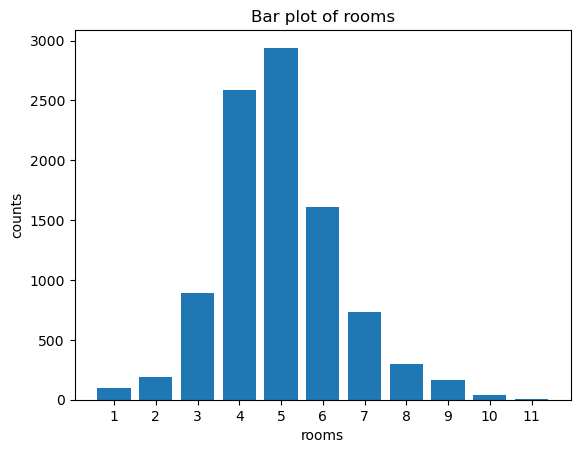

In [26]:
bar_plot(data, 'rooms')

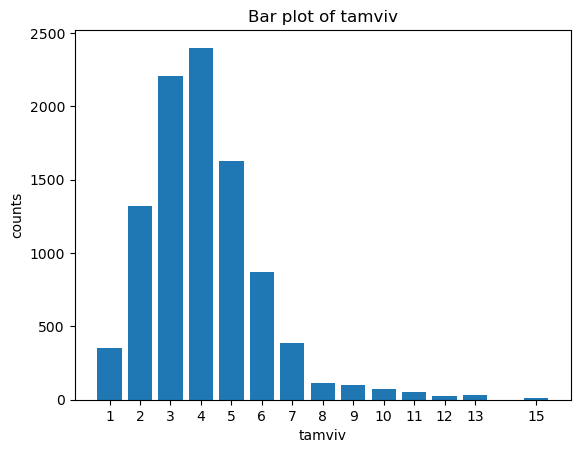

In [27]:
bar_plot(data, 'tamviv')

### Education

Most common years spend at school are 0, 6 or 11. More that 17 years are very rare. Comparing the male and female head of household's year of education, it's can be seen that females have mostly spend 0 years of eduation. Very high values, more than 17, are not present among the females group.

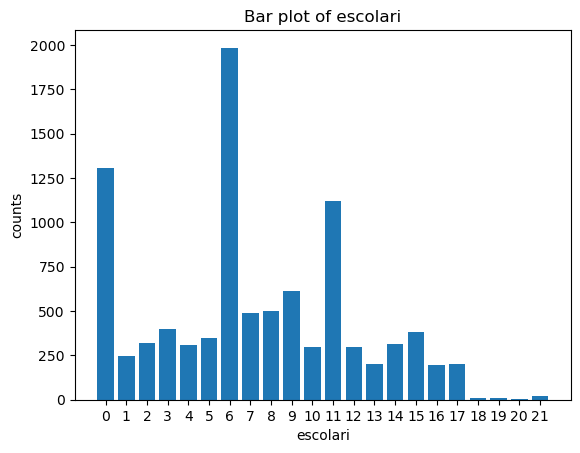

In [28]:
bar_plot(data, 'escolari')

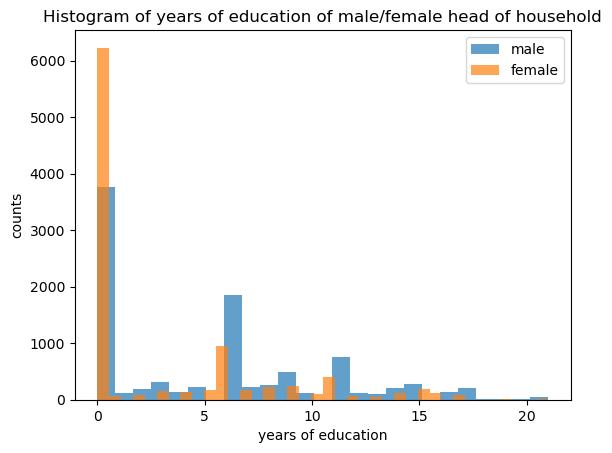

In [29]:
plt.hist(data['edjefe'], bins = 'fd', alpha = 0.7, label = 'male')
plt.hist(data['edjefa'], bins = 'fd', alpha = 0.7, label = 'female')
plt.title('Histogram of years of education of male/female head of household')
plt.xlabel('years of education')
plt.ylabel('counts')
plt.legend()
plt.show()